In [1]:
EXPORT_LATEX = True

%matplotlib inline 
# %matplotlib notebook would provide interactive plots

import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from mthesis.helpers import *  # all functions are in this package

# Boxplot Legend

In [2]:
df = load_all_data()
dft = df

In [3]:
# Manipulate Data
var = "T60"
dft = df
# dft = dft[dft["description"]=="em-iterations"]
dft = dft[dft["reflect-order"]==3]
dft = dft[dft["T60"].isin([0.6])]
dft = dft[dft["em"]==5]
dft = dft[dft["wd"]==1.2]
dft = dft[dft["md"]==0.5]
dft = dft[dft["SNR"]==0]
dft = dft[dft["var-fixed"]==0]
dft = dft[dft["var-val"]==0.1]
dft = dft[dft["n-sources"].isin([3])]
dft = dft[0:1900] # reduce sample size to 200 each
print_summary(dft)

DATA FROM:  {'em-iterations', 'reflect-order'}
n-sources          3
n                250
em-iterations      5
T60             0.60
SNR                0
md              0.50
reflect-order      3
var-fixed          0
var-val         0.10
err-mean        0.29
percent-matched 0.63



Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


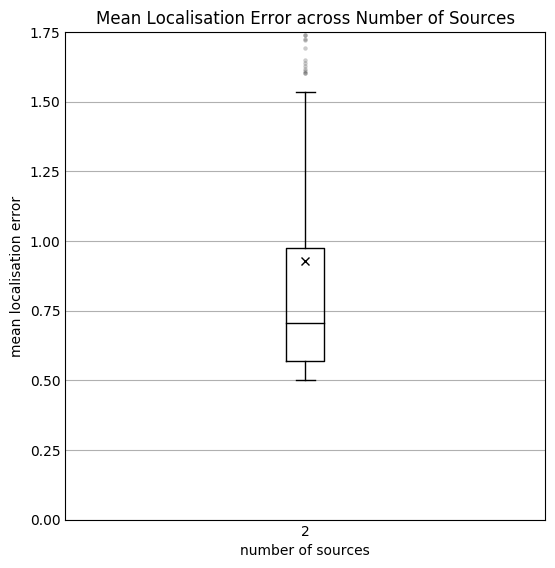

In [9]:
# Joint Boxplot, grouped
dfp = dft.pivot_table("err-mean", index=["n-sources"], columns=var, aggfunc='mean').transpose()

fig = figure( figsize=(6,6.5) ); ax  = fig.add_subplot(111)
idx=0

def shape(x):
    return x*1.5+0.5

dftt = dft.copy()
dftt["err-mean"] = dftt["err-mean"].apply(shape)

bp = dftt.boxplot("err-mean", by=["n-sources"], ax=ax, **boxplot_args)
style_boxplot(bp, None, 0,1)

ax = bp[0].ax
ax.set_ylim([0,1.75])
ax.set_yticks(np.arange(0,1.76, 0.25))
idx+=1

# annotate_props = {'fontsize':14, 'arrowprops':{'arrowstyle':'-|>'}, "textcoords":'offset points'}
# annotate_props2 = {'xytext':(-120, 0), 'fontsize':12, 'color':lms_red, 'backgroundcolor':'w', "textcoords":'offset points'}
# annotate_props3 = {'xytext':(-120, 0), 'fontsize':12, 'color':'gray', 'backgroundcolor':'w', "textcoords":'offset points'}

# # left side
# plt.annotate(xy=[1, 0.57], s="25% quantile", **annotate_props2)
# plt.annotate(xy=[1, 0.69], s="50% quantile", **annotate_props2)
# plt.annotate(xy=[1, 0.95], s="75% quantile", **annotate_props2)
# plt.annotate(xy=[1, 1.65], s="$>1.5*Q_{3,max}$", **annotate_props3)

# # right side
# plt.annotate(xy=[1, 0.50], s="lower whisker", xytext=(50, -30), **annotate_props)
# plt.annotate(xy=[1, 0.71], s="median", xytext=(50, -30), **annotate_props)
# plt.annotate(xy=[1, 0.93], s="mean", xytext=(50, -30), **annotate_props)
# plt.annotate(xy=[1, 1.53], s="upper whisker", **annotate_props, xytext=(50, -30))
# plt.annotate(xy=[1, 1.68], s="outliers", **annotate_props, xytext=(50, -30))


## EXPORT
if EXPORT_LATEX:
    tikz_save("".join([PATH_LATEX_PLOTS, 'boxplot-reference.tex']), strict=True)

## Old way of reading data

In [ ]:
# Configuration

# NAME_EVALUATION = 'mean-err-n-sources'
# NAME_FOLDER = "{}sources"
# NAME_DATA_FILES = '2017-10-04*.txt'  # 1st trials, original speech samples

# NAME_EVALUATION = 'mean-err-n-sources-sample3and5exchanged'
# NAME_FOLDER = "{}sources"
# NAME_DATA_FILES = '2017-10-11*.txt'  # 2nd trials, rearranged speech samples

# NAME_EVALUATION = 'mean-err-n-sources-rnd-T60=0.0'
# NAME_FOLDER = "{}sources-rnd"
# NAME_DATA_FILES = '2017-*results.txt'  # 3rd trials, BASE

# NAME_EVALUATION = 'mean-err-n-sources-rnd-T60=0.3'
# NAME_FOLDER = "{}sources-rnd-T60"
# NAME_DATA_FILES = '2017-*0.3T60*results.txt'  # 4th trials, T60=0.3

# NAME_EVALUATION = 'mean-err-n-sources-rnd-T60=0.6-em=5'
# NAME_FOLDER = "{}sources-rnd-T60"
# NAME_DATA_FILES = '2017-*0.6T60*5em_results.txt'  # 5th trials, T60=0.6, em=5

# NAME_EVALUATION = 'mean-err-n-sources-rnd-T60=0.6-em=10'
# NAME_FOLDER = "{}sources-rnd-T60"
# NAME_DATA_FILES = '2017-*0.6T60*10em_results.txt'  # 6th trials, T60=0.6, em=10

# NAME_EVALUATION = 'mean-err-n-sources-rnd-estimates'
# NAME_FOLDER = "{}sources-rnd-estimates"
# NAME_DATA_FILES = '*results.txt'  # 7th trials, random estimates (benchmark)

In [ ]:
n_sources_range = [1, 2, 3, 4, 5, 6, 7]
results_dict = {}

for s in n_sources_range:
    # define filename format
    files = glob.glob(path.join(PATH_ROOT,NAME_FOLDER.format(s), NAME_DATA_FILES))

    # load data
    dfs = []
    for f in files:
        dfs.append(pd.DataFrame(list(csv.reader(open(f, 'r'), delimiter='\t')), dtype=float))
    try:   
        results = pd.concat(dfs)
    except ValueError:
        continue
    n_trials = len(results)
    n_sources = int((len(results.columns)-1)/5)
    results.drop(results.columns[[n_sources*4+n_sources]], axis=1, inplace=True) # drops empty column
    results.columns = get_col_names(n_sources)
    results.index = ["t{}".format(i+1) for i in range(n_trials)]
    results_dict['{}'.format(n_sources)] = results
    
    # calculate helper columns
    results['n_sources']     = n_sources
    results["err_mean"]      = results.loc[:, "err1":_get_err_col_name(s)[-1]].mean(axis=1)
    results["err_total"]     = results.loc[:, "err1":_get_err_col_name(s)[-1]].sum(axis=1)
    results["perfect_match"] = results["err_total"]<=0.01

try:   
    results = pd.concat(results_dict, ignore_index=True)
except ValueError:
    print("NO DATA FOUND!")

print("SUMMARY:")
summary = results.groupby('n_sources').agg({'x1':'count', 'err_mean':np.mean, 'perfect_match':np.mean}).rename(columns={'x1':'sample size'})
print(summary.transpose())

# print("")
# print("COMPLETE DATA:")
# print(results.sample(5))
if EXPORT_RESULTS:
    results.to_pickle(path.join(PATH_ROOT, NAME_DATAFRAME))
if EXPORT_LATEX:
    summary.transpose().to_latex(PATH_LATEX_SUMMARY_TABLE, column_format="rrrrrrr", bold_rows=True)

## Old way of comparing

In [ ]:
files = glob.glob(path.join(PATH_ROOT, 'mean-err-n-sources-rnd-T60*-dataframe.pkl'))
files2 = glob.glob(path.join(PATH_ROOT, 'mean-err-n-sources-rnd-estimates-dataframe.pkl'))
from pprint import pprint
print("The following files match the criterion:")

dfs = []
for f in files:
    df = pd.read_pickle(f)
    fname = f.split(sep="/")[-1]
    print(fname)
    version = fname[fname.find("rnd-")+4:fname.find("-dataframe")]
    if version=="": version="latest"
    df["version"] = version
    dfs.append(df)

for f in files2:
    df = pd.read_pickle(f)
    fname = f.split(sep="/")[-1]
    print(fname)
    df["version"] = "random"
    dfs.append(df)

dfc = pd.concat(dfs, ignore_index=True)
print("\nSUMMARY:")
print(dfc.groupby(by=["version", "n_sources"]).agg({'x1':'count', 'err_mean':np.mean, 'perfect_match':np.mean}).rename(columns={'x1':'sample size'}))

## Plot with groups 

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from itertools import groupby

def test_table():
    data_table = pd.DataFrame({'version':['v1']*4 + ['v2']*4,
                               'n_sources':(['2']*2 + ['3']*2)*2,
                               'Quantity':[10,20,5,6,4,7,2,1],
                               'Ordered':np.random.randint(0,10,8)
                               })
    return data_table

def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='black')
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]

def label_group_bar_table(ax, df):
    ypos = -.1
    scale = 1./df.index.size
    for level in range(df.index.nlevels)[::-1]:
        pos = 0
        for label, rpos in label_len(df.index,level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale , ypos)
        ypos -= .1

df = dfc.groupby(['n_sources','version']).mean()["err_mean"]
fig = plt.figure(figsize=(17,5))
ax = fig.add_subplot(111)
df.plot(kind='bar',stacked=False,ax=fig.gca(),color=[lms_red,'black', 'gray'])
#Below 3 lines remove default labels
labels = ['' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
ax.set_xlabel('')
label_group_bar_table(ax, df)
fig.subplots_adjust(bottom=.1*df.index.nlevels)

## Check for Normality (Q-Q-Plot)

In [ ]:
import pylab 
import numpy as np
import scipy.stats as stats

def transform(x):
    return np.power(x, -1)

evalruns = ['guessing-at-random', 'base']

pylab.subplots(1,2,figsize=(17, 5))
for desc in evalruns:
    df = matlab2pandas(dirname=desc, save_to=False, summary=True)
    df["err_mean"] = pd.to_numeric(df["err_mean"])
    df_s = df[df["n_sources"]==2]
    pylab.subplot(1,2,evalruns.index(desc)+1)
    stats.probplot(df_s["err_mean"], dist="norm", plot=pylab)
    pylab.title(desc)

pylab.show()

# Significance Analysis

In [ ]:
from scipy.stats import ttest_ind, describe, norm
from statsmodels.formula.api import ols

means = []
stddevs = []

# extract err-mean per n_sources
cat = {}
for n in set(df["n-sources"].values):
    cat[str(n)] = df[df['n-sources']==n]['err-mean']

x = np.linspace(0,1.5,100)
print("DESCRIPTIVE ANALYSIS:")
fig, ax = plt.subplots(1,3, figsize=(17,  6))
for n, c in cat.items():
    dr = describe(c)
    means.append(dr.mean)
    stddevs.append(np.sqrt(dr.variance))
    y = norm.pdf(x, loc=dr.mean, scale=np.sqrt(dr.variance))
    plt.subplot(131)
    plt.plot(x, y, label=n)  # plot gaussian
    print("{} sources: n={:3}, min={:0.3f}, max={:0.3f}, mean={:0.3f}, variance={:0.3f}, std.dev={:0.3f}".format(
        n, dr.nobs, dr.minmax[0], dr.minmax[1], dr.mean, dr.variance, np.sqrt(dr.variance)))
plt.legend()

plt.subplot(132)
plt.boxplot(list(cat.values()), showmeans=True, meanline=True)

plt.subplot(133)
plt.boxplot(list(cat.values()), showmeans=True, meanline=True)
plt.ylim(-0.01, 0.31)
plt.yticks([0, 0.1, 0.2, 0.3])

# This means that given p and t values from a two-tailed test, you would reject the null hypothesis 
# of a greater-than test when p/2 < alpha and t > 0, and of a less-than test when p/2 < alpha and t < 0.    

print("\nT-TEST FOR DIFFERENCE IN MEANS:")
for i1 in set(df["n-sources"].values):
    for i2 in set(df["n-sources"].values):
        if i1!=i2 and i2>i1 and i2<=i1+1:
            ttest = ttest_ind(cat[str(i2)], cat[str(i1)], equal_var=False)
            p_onesided = ttest.pvalue/2
            if p_onesided <= 0.01:sign="***"
            elif p_onesided <= 0.05: sign="**"
            elif p_onesided <= 0.10: sign="*"
            else: sign="(n.s.)"
            print("{}x{}: t={t.statistic:0.3f}, p={p:0.3f} {s:^6}".format(i1, i2, t=ttest, p=p_onesided, s=sign))

print("\nVISUALIZE MEANS AND VARIANCE OF DATA:")

## Custom Boxplot with Lines 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some data...
data = np.random.random((100, 5))
y = data.mean(axis=0)
x = np.random.random(y.size) * 10
x -= x.min()
x.sort()

# Plot a line between the means of each dataset
plt.plot(x, y, 'b-')

# Save the default tick positions, so we can reset them...
locs, labels = plt.xticks() 

plt.boxplot(data, positions=x, notch=True)

# Reset the xtick locations.
#plt.xticks(locs)
plt.show()

## Grid of 3-by-2 Boxplots with lines through means

In [ ]:
# Print Boxplots
ax, i = init_grid((2,3),(17,12))
for val in dfp.index.values:
    dftt = dft[dft[var]==val]
    try:
        bp = dftt.boxplot('err-mean', by=["n-sources"], return_type='both', figsize=(6,  6), showmeans=True, meanline=False, ax=ax[i])
        style_boxplot(bp)
        # plot line through means
        ax[i].plot([1,2,3,4,5,6], *list(dfp[dfp.index==val].values), color=lms_red, linewidth=0.5)
        # Title and legend are applied in LaTeX
        # ax[i].set_title("{}={}".format(var,val))
        # ax[i].legend([Rectangle((0, 0), 0, 0, alpha=0.0)], ['em={}'.format(int(val))], handlelength=0)
        i+=1
    except ValueError:
        continue

plt.tight_layout(.5)

if EXPORT_LATEX:
        tikz_save("".join([PATH_LATEX_PLOTS, 'boxplot-{}-{}.tex'.format(var, int(val))]))

## All Data Lineplot of Mean Err and Percent Matched

In [ ]:
ax, i = init_grid((1,2), (12,3))
cols = ['err-mean', 'percent-matched']
for col in cols:
    dft.pivot_table(col, index=['n-sources'], aggfunc='mean').plot(**DEFAULT_LINE_PLOT_ARGS, grid=True, ax=ax[i], title=col)
    style_line_plot("", "", grid='x', ax=ax[i])
    adjust_y_axis(0.1,1,0,1.01,ax[i])
    i+=1

In [ ]:
ax, i = init_grid((1,2),(17,6))
cols = ['err-mean', 'percent-matched']
axis_param = [[0.2, 0, 0, 2.01],[0.1, 0, 0,1.01]]
for col in cols:
    a = dft.pivot_table(col, index=['n-sources'], columns=[var], aggfunc='mean').plot(**DEFAULT_LINE_PLOT_ARGS, grid=True, ax=ax[i], title=col)
#     a.set_ylim([0,1])
    style_line_plot("number of sources", "", grid='x', ax=ax[i])
#     adjust_y_axis(*axis_param[i], a)
    i+=1
    if EXPORT_LATEX:
        tikz_save("".join([PATH_LATEX_PLOTS, 'plot_{}_{}.tex'.format(desc, col)]),
        figureheight = '\\figureheight',
        figurewidth = '\\figurewidth'
        )

## EM Iterations

In [ ]:
# Print Means in Lineplot
ax, i = init_grid((1,2),(15,8))
cols = ['err-mean', 'percent-matched']
axis_param = [[0.1, 0, 0, 1.01],[0.1, 0, 0,1.01]]
for col in cols:
    a = dft.pivot_table(col, index=['n-sources'], columns=[var], aggfunc='mean').plot(**DEFAULT_LINE_PLOT_ARGS, grid=True, ax=ax[i], title=col)
#     a.set_ylim([0,1])
    style_line_plot("number of sources", "", grid='x', ax=ax[i])
    adjust_y_axis(*axis_param[i], a)
    i+=1
    if EXPORT_LATEX:
        tikz_save("".join([PATH_LATEX_PLOTS, 'lineplot-{}-{}.tex'.format(var, col)]))